In [ ]:
import numpy as np
from time import perf_counter as time

def gauss_seidel(f):
    newf = f.copy()

    for i in range(1,newf.shape[0]-1):
        for j in range(1,newf.shape[1]-1):
            newf[i,j] = 0.25 * (newf[i,j+1] + newf[i,j-1] +
                                   newf[i+1,j] + newf[i-1,j])

    return newf


def setup(x):
    arr=np.random.random((x,x))*1000
    arr[0,:]=0
    arr[:,0]=0
    arr[:,-1]=0
    arr[-1,:]=0
    for i in range(1000):
        arr = gauss_seidel(arr)

def measure(start, stop, step):
    times=[]
    for i in range(start, stop, step):
        t1=time()
        setup(i)
        times.append(time()-t1)
    return times

if __name__=="__main__":
    #setup(100)
    for i in range(100, 210, 10):
        t1=time()
        setup(i)
        print(f"{time()-t1} seconds for {i}x{i} grid")

In [6]:
!python3 -m line_profiler GaussSeidel.py.lprof

Timer unit: 1e-06 s

Total time: 10.3462 s
File: GaussSeidel.py
Function: gauss_seidel at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           @profile
     6                                           def gauss_seidel(f):
     7        10       5688.0    568.8      0.1      newf = f.copy()
     8                                               
     9      9990       1245.0      0.1      0.0      for i in range(1,newf.shape[0]-1):
    10   9970020    1180159.0      0.1     11.4          for j in range(1,newf.shape[1]-1):
    11  29880120    6199055.0      0.2     59.9              newf[i,j] = 0.25 * (newf[i,j+1] + newf[i,j-1] +
    12  19920080    2960055.0      0.1     28.6                                     newf[i+1,j] + newf[i-1,j])
    13                                               
    14        10         22.0      2.2      0.0      return newf

Total time: 18.3548 s
File: GaussSeidel.py
Function: setup at line 1

As can be seen from the line profiler the part that needs to be optimized is the nested for loop in the gauss_seidel(f) function.

![cythonAnnotation](CythonAnnotation.png)

The cython annotation shows that the nested for loops need to be be optimized

In [ ]:
import numpy as np
from time import perf_counter as time
import cythonfnOpt
import cythonfn

def setup(x, ver):
    arr=np.random.random((x,x))*100000000
    arr[0,:]=0
    arr[:,0]=0
    arr[:,-1]=0
    arr[-1,:]=0
    if ver==0:
        for i in range(1000):
            arr = cythonfnOpt.gauss_seidelOpt(arr)
    else:
        for i in range(1000):
            arr = cythonfn.gauss_seidel(arr)

def measure(start, stop, step, ver):
    times=[]
    for i in range(start, stop, step):
        t1=time()
        setup(i, ver)
        times.append(time()-t1)
    return times

if __name__=="__main__":
    print("Cython with type definition and memoryviews")
    for i in range(100, 210, 10):
        t1=time()
        setup(i,0)
        print(f"{time()-t1} seconds for {i}x{i} grid")
    print("Cython without modifications")
    for i in range(100, 210, 10):
        t1=time()
        setup(i,1)
        print(f"{time()-t1} seconds for {i}x{i} grid")

import numpy as np  
cimport numpy as np

def gauss_seidel(f):

    newf = f.copy()  
    for i in range(1,newf.shape[0]-1):
        for j in range(1,newf.shape[1]-1):
            newf[i,j] = 0.25 * (newf[i,j+1] + newf[i,j-1] +
                                   newf[i+1,j] + newf[i-1,j])
    
    return newf

cimport cython  
import numpy as np  
cimport numpy as np  
@cython.boundscheck(False)
  
def gauss_seidelOpt(double[:, :] f):

    cdef double[:, :] newf
    cdef unsigned int i, j
    newf = np.copy(f)
    for i in range(1,newf.shape[0]-1):
        for j in range(1,newf.shape[1]-1):
            newf[i][j] = 0.25 * (newf[i][j+1] + newf[i][j-1] +
                                   newf[i+1][j] + newf[i-1][j])
    
    return newf

# Task 1.4
The improvements in performance from the cython optimizations can be seen in the graph below. The optimized version with memory views and type definition improved performance by up to 50x

In [ ]:
import numpy as np
from time import perf_counter as time

def gauss_seidel(f):
    newf = np.zeros(f.shape)

    newf[1:-1, 1:-1] = 0.25 * ((np.roll(f,1,axis=1)[1:-1, 1:-1]) +
                            (np.roll(f,-1,axis=1)[1:-1, 1:-1]) +
                            (np.roll(f,1,axis=0)[1:-1, 1:-1]) +
                            (np.roll(f,-1,axis=0)[1:-1, 1:-1]))
    return newf



def setup(x):
    arr=np.random.random((x,x))*1000
    arr[0,:]=0
    arr[:,0]=0
    arr[:,-1]=0
    arr[-1,:]=0
    for i in range(1000):
        arr = gauss_seidel(arr)

def measure(start, stop, step):
    times=[]
    for i in range(start, stop, step):
        t1=time()
        setup(i)
        times.append(time()-t1)
    return times

if __name__=="__main__":
    for i in range(100, 210, 10):
        t1=time()
        setup(i)
        print(time()-t1)

In [ ]:
import cupy as cp
import torch as tc
from time import perf_counter as time

def gauss_seidelPytorch(f):
    newf = tc.zeros(f.shape).cuda()

    newf[1:-1, 1:-1] = 0.25 * ((tc.roll(f,1,dims=1)[1:-1, 1:-1]) +
                            (tc.roll(f,-1,dims=1)[1:-1, 1:-1]) +
                            (tc.roll(f,1,dims=0)[1:-1, 1:-1]) +
                            (tc.roll(f,-1,dims=0)[1:-1, 1:-1]))
    return newf

def gauss_seidelCuPy(f):
    newf = cp.zeros(f.shape)

    newf[1:-1, 1:-1] = 0.25 * ((cp.roll(f,1,axis=1)[1:-1, 1:-1]) +
                            (cp.roll(f,-1,axis=1)[1:-1, 1:-1]) +
                            (cp.roll(f,1,axis=0)[1:-1, 1:-1]) +
                            (cp.roll(f,-1,axis=0)[1:-1, 1:-1]))
    return newf




def setupPytorch(x):
    arr=(tc.randint(1000, (x,x))).cuda()
    arr[0,:]=0
    arr[:,0]=0
    arr[:,-1]=0
    arr[-1,:]=0
    for i in range(1000):
        arr = gauss_seidelPytorch(arr)
    tc.cuda.synchronize()

def setupCuPy(x):
    arr=(cp.random.random((x,x))*1000)
    arr[0,:]=0
    arr[:,0]=0
    arr[:,-1]=0
    arr[-1,:]=0
    for i in range(1000):
        arr = gauss_seidelCuPy(arr)
    cp.cuda.Stream.null.synchronize()

if __name__=="__main__":
    for i in range(1, 10):
      #"Warmup" for GPU
      setupPytorch(i)
      setupCuPy(i)
    print("Pytorch:")
    for i in range(100, 1000, 100):
        t1=time()
        setupPytorch(i)
        print(f"{time()-t1} seconds for {i}x{i} gridsize")
    print("CuPy:")
    for i in range(100, 1000, 100):
        t1=time()
        setupCuPy(i)
        print(f"{time()-t1} seconds for {i}x{i} gridsize")

Pytorch:
0.16408272900002885 seconds for 100x100 gridsize
0.2145513039999969 seconds for 200x200 gridsize
0.40635596899983284 seconds for 300x300 gridsize
0.46771740600001976 seconds for 400x400 gridsize
0.6084029510000164 seconds for 500x500 gridsize
0.7253588040000523 seconds for 600x600 gridsize
0.7690150620001077 seconds for 700x700 gridsize
0.8945860139999695 seconds for 800x800 gridsize
1.0892271410000376 seconds for 900x900 gridsize
CuPy:
0.4053456219999134 seconds for 100x100 gridsize
0.40539443700004085 seconds for 200x200 gridsize
0.4121332039999288 seconds for 300x300 gridsize
0.4260079450000376 seconds for 400x400 gridsize
0.41969555299988315 seconds for 500x500 gridsize
0.45183187399993585 seconds for 600x600 gridsize
0.42812994199994137 seconds for 700x700 gridsize
0.4973929279999538 seconds for 800x800 gridsize
0.6204471559999547 seconds for 900x900 gridsize


In [ ]:
import os

import numpy as np
from time import perf_counter as time
import h5py

filename = "newgrid_results.hdf5"

def gauss_seidel(f):
    newf = np.zeros(f.shape)

    newf[1:-1, 1:-1] = 0.25 * ((np.roll(f,1,axis=1)[1:-1, 1:-1]) +
                            (np.roll(f,-1,axis=1)[1:-1, 1:-1]) +
                            (np.roll(f,1,axis=0)[1:-1, 1:-1]) +
                            (np.roll(f,-1,axis=0)[1:-1, 1:-1]))
    return newf



def setup(x):
    arr=np.random.random((x,x))*1000
    arr[0,:]=0
    arr[:,0]=0
    arr[:,-1]=0
    arr[-1,:]=0
    for i in range(1000):
        arr = gauss_seidel(arr)

    # store the result to HDF5 file
    with h5py.File(filename, "a") as f:
        dataset_name = f"{x}x{x}/newgrid"
        dset = f.create_dataset(dataset_name, data=arr)
        dset.attrs["grid_size"] = x
        dset.attrs["iterations"] = 1000
        dset.attrs["description"] = f"Gauss-Seidel result for {x}x{x} grid"

    print(f"Saved {x}x{x} grid to {filename} under dataset '{dataset_name}'")

if __name__=="__main__":
    if os.path.exists(filename):
        os.remove(filename)

    # You can adjust this to any desired size for storage
    # Modify this to customize the size
    for i in range(100, 210, 10):
        t1=time()
        setup(i)
        print(f"{time()-t1} seconds for {i} x {i} grid")

![plot](GaussSeidelComparison.png)

# Task 1.7  
The GPU versions were run on Google Colab T4 GPU while others were run on a M1 Macbook Pro (16GB RAM)  
As can be seen from the graph the unoptimized (meaning no memory views or type definitions) cython version has no noticible improvement from the baseline version. However when utilizing cython + memory views and type definition the improvement is substantial. Although using CPU vectorization further improves the results. The PyTorch implementation shows lower overhead in comparison to CuPy but from the above cell it becomes apparent that CuPy has better scaling in regards to grid size. So for smaller gridsizes optimized cython and CPU vectorization are better due to lower overhead but GPU vectorization come on top in larger grid sizes. 

In [ ]:
import h5py
import numpy as np

filename = "newgrid_results.hdf5"

def list_datasets():
    with h5py.File(filename, "r") as f:
        print("Datasets in the file:")

        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"📂 {name} - shape: {obj.shape}, dtype: {obj.dtype}")

        f.visititems(print_structure)


def read_dataset(grid_size):
    with h5py.File(filename, "r") as f:
        dataset_name = f"{grid_size}x{grid_size}/newgrid"
        if dataset_name in f:
            dataset = f[dataset_name]
            data = dataset[:]
            print(f"Loaded {dataset.attrs.get('description', 'No description')}")
            print("Data shape:", data.shape)
            np.set_printoptions(threshold=np.inf)
            print("Data:\n", data)
        else:
            print(f"Dataset {dataset_name} not found!")


if __name__ == "__main__":
    list_datasets()

    # You can adjust this to any desired size for display
    # Modify this to customize the viewing size
    grid_size = 100
    read_dataset(grid_size)


1.9544792919768952


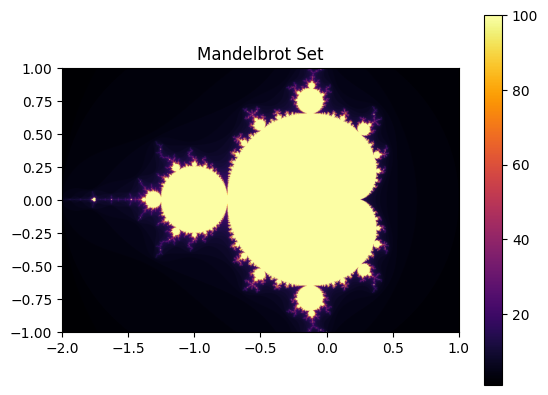

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter as time

def mandelbrot(c, max_iter=100):
    """Computes the number of iterations before divergence."""
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

def mandelbrot_set(width, height, x_min, x_max, y_min, y_max, max_iter=100):
    """Generates the Mandelbrot set image."""
    x_vals = np.linspace(x_min, x_max, width)
    y_vals = np.linspace(y_min, y_max, height)
    image = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            c = complex(x_vals[j], y_vals[i])
            image[i, j] = mandelbrot(c, max_iter)

    return image

# Parameters
width, height = 1000, 800
x_min, x_max, y_min, y_max = -2, 1, -1, 1

# Generate fractal
t1=time()
image = mandelbrot_set(width, height, x_min, x_max, y_min, y_max)
print(time()-t1)
# Display
plt.imshow(image, cmap='inferno', extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.title("Mandelbrot Set")
plt.show()

0.20655050000641495


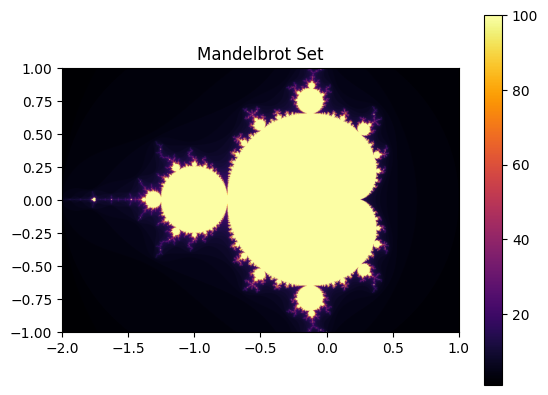

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter as time
import cythonMandelbrot

# Parameters
width, height = 1000, 800
x_min, x_max, y_min, y_max = -2, 1, -1, 1

# Generate fractal
t1=time()
image = cythonMandelbrot.mandelbrot_set(width, height, x_min, x_max, y_min, y_max)
print(time()-t1)
# Display
plt.imshow(image, cmap='inferno', extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.title("Mandelbrot Set")
plt.show()

0.06680099700042774


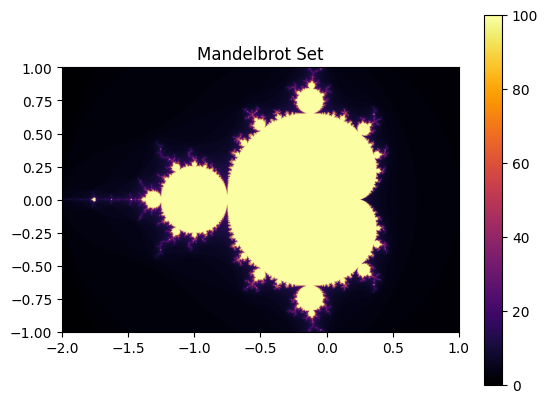

In [13]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
from time import perf_counter as time

def mandelbrot(c, max_iter=100):
    """Computes the number of iterations before divergence."""
    z = tc.zeros(c.shape).cuda()
    add=tc.zeros(c.shape).cuda()
    for n in range(max_iter):
        z=tc.where(tc.abs(z)<2, z * z + c, z)
        add+=tc.abs(z)<2
    return add

def mandelbrot_set(width, height, x_min, x_max, y_min, y_max, max_iter=100):
    """Generates the Mandelbrot set image."""
    x_vals =tc.Tensor(tc.linspace(x_min, x_max, width))
    y_vals =tc.transpose(tc.atleast_2d(tc.linspace(y_min*1j, y_max*1j, height)),0,1)
    cT=tc.add(x_vals.unsqueeze(0).repeat(height,1), y_vals).cuda()
    return mandelbrot(cT, max_iter)

# Parameters
width, height = 1000, 800
x_min, x_max, y_min, y_max = -2, 1, -1, 1

# Generate fractal
t1=time()
image = mandelbrot_set(width, height, x_min, x_max, y_min, y_max)
tc.cuda.synchronize()
print(time()-t1)
# Display
plt.imshow(tc.Tensor.cpu(image), cmap='inferno', extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.title("Mandelbrot Set")
plt.show()

1.1290506600003027


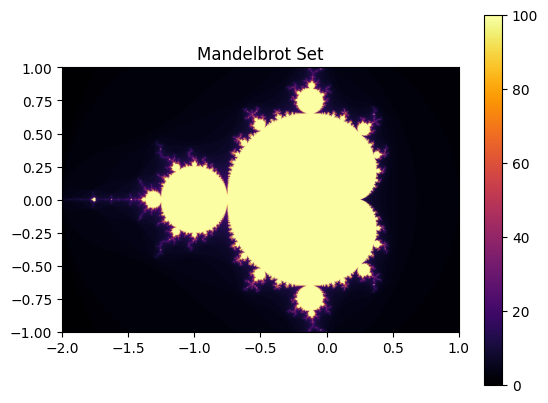

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter as time

def mandelbrot(c, max_iter=100):
    """Computes the number of iterations before divergence."""
    z = np.zeros(c.shape)
    add=np.zeros(c.shape)
    for n in range(max_iter):
        z=np.where(np.abs(z)<2, z * z + c, z)
        add+=np.abs(z)<2
    return add

def mandelbrot_set(width, height, x_min, x_max, y_min, y_max, max_iter=100):
    """Generates the Mandelbrot set image."""
    x_vals = [np.linspace(x_min, x_max, width)]*height
    y_vals = np.atleast_2d(np.linspace(y_min*1j, y_max*1j, height)).T
    image = np.zeros((height, width))
    cT=x_vals+y_vals
    return mandelbrot(cT, max_iter)

# Parameters
width, height = 1000, 800
x_min, x_max, y_min, y_max = -2, 1, -1, 1

# Generate fractal
t1=time()
image = mandelbrot_set(width, height, x_min, x_max, y_min, y_max)
print(time()-t1)
# Display
plt.imshow(image, cmap='inferno', extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.title("Mandelbrot Set")
plt.show()

# Task B.3
Once again the GPU version was run on a Google Colab T4 GPU and the other versions were run on a M1 Macbook Pro (16GB RAM)  
The unoptimized version took approximately 1.95 seconds with 100 iterations.
The cython optimized version took roughly 0.2 seconds.
The GPU vectorized version took roughly 0.067 seconds.
The CPU vectorized version took roughly 1.12 seconds.  

As for the reason why the cython optimized version took less time than the CPU vectorized version might be due to fewer memory accesses needed by the cython version. Larger chunks of memory are read which might incur time waiting for memory transfer and the cycles saved might not have been enough to offset this. And since the the GPU has higher memory bandwith it might explain why the GPU vectorized version outperforms both of the other optimizations
